# Aula 04: Classificação

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math

# Sumário

## Objetivos

1. Implementar o método de regressão logística usado em problemas de classificação;
2. Implementar uma extensão do método fazendo regularização com a norma $L_2$ (i.e. _Ridge regression_).

## Exercícios

### Parte 1: Regressão Logística
- Exercício 1: Preparação dos dados
- Exercício 2: Regressão logística - método do gradiente
- Exercício 3: Regressão logística - scikit-learn

### Parte 2: Regularização
- Exercício 4: Preparação dos dados
- Exercício 5: Regressão logística com regularização - método do gradiente
- Exercício 6: Regressão logística com regularização - scikit-learn

# Parte 1: Regressão logística

## Revisão teórica

### Motivação
Muitos problemas práticos de aprendizado de máquina envolvem **classificação binária**, isto é, prever uma entre duas categorias (por exemplo, **sim/não**, **0/1**, **sucesso/falha**). Nesses casos, não faz sentido usar regressão linear convencional, pois ela produz valores contínuos não limitados, podendo extrapolar além do intervalo [0,1]. Para problemas de classificação, desejamos em vez disso estimar diretamente a **probabilidade** de um evento binário ocorrer, dado um vetor de atributos de entrada.

### Modelo de Regressão Logística
A **regressão logística** modela diretamente a probabilidade de um evento binário e permite definir um critério para obter uma fronteira de decisão bem definida. Para obter saídas probabilísticas, aplicamos a função sigmoide a uma combinação linear:

$$
f_{\mathbf{w},b}(\mathbf{x}) = g(\mathbf{w}\cdot \mathbf{x} + b)\,, \tag{1}
$$
$$
g(z) = \frac{1}{\,1 + e^{-z}\,}\,. \tag{2}
$$
A sigmoide é monotônica e mapeia $\mathbb{R}$ para $(0,1)$; logo, $f_{\mathbf{w},b}(\mathbf{x})$ é sempre interpretável como uma probabilidade. O hiperplano $\mathbf{w}\cdot\mathbf{x}+b=0$ corresponde a $f_{\mathbf{w},b}=0.5$.

### Função de Custo
Ajustamos $(\mathbf{w}, b)$ minimizando a média da perda logarítmica binária, apropriada para alvos Bernoulli:
$$
J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \Big[ \text{loss}\!\big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}),\, y^{(i)}\big) \Big] \tag{3}
$$
$$
\text{loss}\big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}),\, y^{(i)}\big) = -\,y^{(i)} \log\!\Big(f_{\mathbf{w},b}\big( \mathbf{x}^{(i)} \big)\Big)\;-\;\big(1 - y^{(i)}\big)\,\log\!\Big(1 - f_{\mathbf{w},b}\big( \mathbf{x}^{(i)} \big)\Big)\,. \tag{4}
$$

Se $y^{(i)}=1$, o segundo termo se anula; já caso $y^{(i)}=0$, o primeiro termo se anula.

### Gradiente da Função de Custo
As derivadas parciais podem ser obtidos com a regra da cadeia e possuem a seguinte forma:
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \frac{1}{m}\sum_{i=0}^{m-1} \Big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}\Big)\,x_{j}^{(i)}\,, \quad \text{para cada } j=0,1,\dots,n-1\,. \tag{5a}
$$

$$
\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}\sum_{i=0}^{m-1} \Big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}\Big)\,, \tag{5b}
$$
As expressões acima revelam que o gradiente do custo em relação a cada peso $w_j$ é proporcional à média dos erros *$(\text{previsão} - \text{valor real})$* multiplicados pelo respectivo atributo $x_j$. Já o gradiente em relação a $b$ (termo de bias) é a média simples dos erros $(f_{\mathbf{w},b}(\mathbf{x}) - y)$.

**Embora a forma lembre a da regressão linear, aqui $f_{\mathbf{w},b}$ é sigmoidal.**

### Ajuste de Parâmetros com o Método do Gradiente
Para minimizar $J(\mathbf{w},b)$ de forma iterativa, utilizamos o **método do gradiente**. Inicializamos os pesos $\mathbf{w}$ e bias $b$ (por exemplo, com zeros ou valores pequenos aleatórios) e então atualizamos os parâmetros repetidamente na direção oposta ao gradiente, com um passo proporcional à **taxa de aprendizado** $\alpha > 0$. A regra de atualização em cada iteração é dada por:
$$
\begin{align*}
& \text{Repeat } \{ \\
& \quad b \;:=\; b \;-\; \alpha \;\frac{\partial J(\mathbf{w},b)}{\partial b}, \tag{6a} \\
& \quad w_j \;:=\; w_j \;-\; \alpha \;\frac{\partial J(\mathbf{w},b)}{\partial w_j}, \quad \text{para } j = 0,\ldots,n-1. \tag{6b}\\
& \}
\end{align*}
$$
Esse procedimento é repetido iterativamente até que $J(\mathbf{w},b)$ convirja para um mínimo (ou até atingir um número máximo de épocas).

### Interpretação Probabilística e Regra de Decisão
Um dos principais atrativos da regressão logística é a sua **interpretação probabilística**. A saída do modelo $f_{\mathbf{w},b}(\mathbf{x})$ pode ser entendida como a probabilidade estimada de $y=1$ dado o vetor de atributos $\mathbf{x}$ – isto é, $f_{\mathbf{w},b}(\mathbf{x}) \approx P(y=1 \mid \mathbf{x})$. Por exemplo, se $f_{\mathbf{w},b}(\mathbf{x}) = 0.85$, o modelo estima **85% de chance** de o exemplo pertença à classe positiva ($y=1$). Essa interpretação é coerente com a forma funcional do modelo: estamos basicamente ajustando uma distribuição de Bernoulli, cuja média (probabilidade de sucesso) depende de $\mathbf{x}$ através da função sigmoide.

Para utilizar o modelo em tarefas de classificação, é preciso converter a probabilidade prevista em um **rótulo binário** $\hat{y}$. A regra de decisão mais comum é aplicar um **limiar de 0.5**:

- Se $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) \geq 0.5$, então classificamos $\hat{y}^{(i)} = 1$ (classe positiva).  
- Caso contrário ($f_{\mathbf{w},b}(\mathbf{x}^{(i)}) < 0.5$), classificamos $\hat{y}^{(i)} = 0$ (classe negativa).

### Resumo
A regressão logística combina um modelo linear com a sigmoide para produzir probabilidades em $(0,1)$, otimizadas via perda logarítmica e gradiente descendente, resultando em um classificador binário simples, interpretável e eficaz.


## Exercício 1: Preparação dos dados

Como no notebook da Aula 3, vamos usar dados simplificados. Estes dados descrevem o resultado do processo de admissão em uma universidade americana fictícia, em função das notas obtidas em dois exames distintos. Cada linha corresponde a um estudante e contém 3 colunas: duas colunas com notas numéricas dos exames 1 e 2, e uma terceira coluna com uma variável binária (0/1), onde 1 significa que o estudante foi aceito.

### Criando o conjunto de dados

In [94]:
!mkdir -p ./data
!touch ./data/admissions.csv

In [95]:
admissions_data = """34.62365962451697,78.0246928153624,0
30.28671076822607,43.89499752400101,0
35.84740876993872,72.90219802708364,0
60.18259938620976,86.30855209546826,1
79.0327360507101,75.3443764369103,1
45.08327747668339,56.3163717815305,0
61.10666453684766,96.51142588489624,1
75.02474556738889,46.55401354116538,1
76.09878670226257,87.42056971926803,1
84.43281996120035,43.53339331072109,1
95.86155507093572,38.22527805795094,0
75.01365838958247,30.60326323428011,0
82.30705337399482,76.48196330235604,1
69.36458875970939,97.71869196188608,1
39.53833914367223,76.03681085115882,0
53.9710521485623,89.20735013750205,1
69.07014406283025,52.74046973016765,1
67.94685547711617,46.67857410673128,0
70.66150955499435,92.92713789364831,1
76.97878372747498,47.57596364975532,1
67.37202754570876,42.83843832029179,0
89.67677575072079,65.79936592745237,1
50.534788289883,48.85581152764205,0
34.21206097786789,44.20952859866288,0
77.9240914545704,68.9723599933059,1
62.27101367004632,69.95445795447587,1
80.1901807509566,44.82162893218353,1
93.114388797442,38.80067033713209,0
61.83020602312595,50.25610789244621,0
38.78580379679423,64.99568095539578,0
61.379289447425,72.80788731317097,1
85.40451939411645,57.05198397627122,1
52.10797973193984,63.12762376881715,0
52.04540476831827,69.43286012045222,1
40.23689373545111,71.16774802184875,0
54.63510555424817,52.21388588061123,0
33.91550010906887,98.86943574220611,0
64.17698887494485,80.90806058670817,1
74.78925295941542,41.57341522824434,0
34.1836400264419,75.2377203360134,0
83.90239366249155,56.30804621605327,1
51.54772026906181,46.85629026349976,0
94.44336776917852,65.56892160559052,1
82.36875375713919,40.61825515970618,0
51.04775177128865,45.82270145776001,0
62.22267576120188,52.06099194836679,0
77.19303492601364,70.45820000180959,1
97.77159928000232,86.7278223300282,1
62.07306379667647,96.76882412413983,1
91.56497449807442,88.69629254546599,1
79.94481794066932,74.16311935043758,1
99.2725269292572,60.99903099844988,1
90.54671411399852,43.39060180650027,1
34.52451385320009,60.39634245837173,0
50.2864961189907,49.80453881323059,0
49.58667721632031,59.80895099453265,0
97.64563396007767,68.86157272420604,1
32.57720016809309,95.59854761387875,0
74.24869136721598,69.82457122657193,1
71.79646205863379,78.45356224515052,1
75.3956114656803,85.75993667331619,1
35.28611281526193,47.02051394723416,0
56.25381749711624,39.26147251058019,0
30.05882244669796,49.59297386723685,0
44.66826172480893,66.45008614558913,0
66.56089447242954,41.09209807936973,0
40.45755098375164,97.53518548909936,1
49.07256321908844,51.88321182073966,0
80.27957401466998,92.11606081344084,1
66.74671856944039,60.99139402740988,1
32.72283304060323,43.30717306430063,0
64.0393204150601,78.03168802018232,1
72.34649422579923,96.22759296761404,1
60.45788573918959,73.09499809758037,1
58.84095621726802,75.85844831279042,1
99.82785779692128,72.36925193383885,1
47.26426910848174,88.47586499559782,1
50.45815980285988,75.80985952982456,1
60.45555629271532,42.50840943572217,0
82.22666157785568,42.71987853716458,0
88.9138964166533,69.80378889835472,1
94.83450672430196,45.69430680250754,1
67.31925746917527,66.58935317747915,1
57.23870631569862,59.51428198012956,1
80.36675600171273,90.96014789746954,1
68.46852178591112,85.59430710452014,1
42.0754545384731,78.84478600148043,0
75.47770200533905,90.42453899753964,1
78.63542434898018,96.64742716885644,1
52.34800398794107,60.76950525602592,0
94.09433112516793,77.15910509073893,1
90.44855097096364,87.50879176484702,1
55.48216114069585,35.57070347228866,0
74.49269241843041,84.84513684930135,1
89.84580670720979,45.35828361091658,1
83.48916274498238,48.38028579728175,1
42.2617008099817,87.10385094025457,1
99.31500880510394,68.77540947206617,1
55.34001756003703,64.9319380069486,1
74.77589300092767,89.52981289513276,1"""

with open('./data/admissions.csv', 'w') as f:
    f.write(admissions_data)

# Importando dados

X_features = ['Exam 1 score', 'Exam 2 score']
y_name = ['Admitted']
data = pd.read_csv("./data/admissions.csv", header=None, names=X_features + y_name)

### 1.a) Crie a matriz de treino $X_{\rm train}$, o vetor de variáveis alvo $y_{\rm train}$

In [96]:
# ---- INSIRA SEU CÓDIGO AQUI
from sklearn.model_selection import train_test_split
X_data = data.iloc[:,0:2]
y_data = data.iloc[:,2]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.30, random_state=42)
# ----

### 1b) Explore (rapidamente) os dados

**Inspecione a tabela com funcionalidade da biblioteca pandas e faça um scatterplot dos dados, usando a coluna "Admitted" como cor do marcador.**

_Obs: não gaste muito tempo neste exercício. Por outro lado, é sempre importante inspecionar rapidamente os dados._


> Besides `display()`, you can use several other methods to inspect a pandas DataFrame:
>
> - `.head()`: Shows the first 5 rows (or a specified number) of the DataFrame. Useful for a quick look at the data structure.
> - `.info()`: Prints a concise summary of the DataFrame, including the index dtype > and column dtypes, non-null values and memory usage.
> - `.describe()`: Generates descriptive statistics of the DataFrame's numerical > columns, such as count, mean, standard deviation, minimum, and maximum.
> - `.shape`: Returns a tuple representing the dimensionality of the DataFrame (rows, > columns).

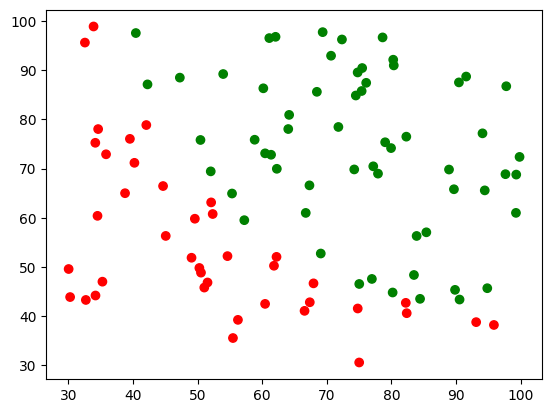

In [97]:
# ---- INSIRA SEU CÓDIGO AQUI
plt.scatter(data.iloc[:,0],data.iloc[:,1], color = np.where(data.iloc[:,2] == 1, "green", "red"))
# ----

## Exercício 2: Regressão logística - Método do gradiente

O objetivo deste exercício é implementar o método do gradiente para regressão logística.

### 2.a) Implemente as funções do método do gradiente em regressão logística

Será necessário definir as seguintes funções:

- `sigmoid` define a função sigmóide
- `compute_cost` implementa a equação (3) acima;
- `compute_gradient` implementa as equações (5a) e (5b) acima;
- `gradient_descent` implementa o método do gradiente segundo as equações (6a) e (6b) acima;
- `predict` implementa o critério de corte que define a etiqueta prevista pelo modelo.

In [98]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
    """

    # ---- INSIRA SEU CÓDIGO AQUI
    g = 1/(1+np.exp(-z))
    # ----

    return g


def f_wb(X, w, b):
  return sigmoid(w @ X.T + b)

def compute_cost(X, y, w, b):
    """
    Computes the cost $J(\vec{w}, b)$ for a logistic regression model.

    Args:
      X (ndarray (m, n)): Data, m examples with n features each
      y (ndarray (m,))  : target values
      w (ndarray (n,))  : model weight parameters
      b (scalar)        : model bias parameter

    Returns:
      cost (scalar): cost
    """

    # ---- INSIRA SEU CÓDIGO AQUI
    m = len(y)
    f = f_wb(X,w,b)
    losses = -y * np.log(f) - (1-y)*np.log(1-f)

    cost = losses.sum()/m
    # ----

    return cost


def compute_gradient(X, y, w, b):
    """
    Computes the gradient for logistic regression
    Args:
      X (ndarray (m, n)): Data, m examples with n features each
      y (ndarray (m,))  : target values
      w (ndarray (n,))  : model weight parameters
      b (scalar)        : model bias parameter

    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b.
    """

    # ---- INSIRA SEU CÓDIGO AQUI
    m = len(y)
    dif = f_wb(X,w,b) - y
    dj_dw = 1/m * (X.T @ dif)
    dj_db = 1/m * dif.sum()
    # ----

    return dj_dw, dj_db


def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray (m, n)) : Data, m examples with n features each
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): initial model weight parameters
      b_in (scalar)      : initial model bias parameter
      alpha (float)      : Learning rate
      num_iters (int)    : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,))                   : Updated values of parameters
      b (scalar)                         : Updated value of parameter
      J_history (ndarray (num_iters,))   : History of cost values
      w_history (ndarray (num_iters, n)) : History of parameters w
      b_history (ndarray (num_iters,))   : History of parameters b
      """

    # ---- INSIRA SEU CÓDIGO AQUI
    w = w_in
    b = b_in
    w_history = [w]
    b_history = [b]
    J_history = [compute_cost(X,y,w,b)]

    for i in range(num_iters):
      dj_dw, dj_db = compute_gradient(X,y,w,b)
      w -= alpha*dj_dw
      b -= alpha*dj_db

      w_history.append(w)
      b_history.append(b)
      J_history.append(compute_cost(X,y,w,b))
    # ----

    return w, b, J_history, w_history, b_history


def predict(X, w, b):
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w

    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
    """

    # ---- INSIRA SEU CÓDIGO AQUI
    y_pred = (sigmoid(w @ X.T + b)> 0.5).astype(int)
    # ----

    return y_pred

### 2.b) Treine o modelo, faça previsões e inspecione graficamente os resultados

Faça a regressão logística nos dados e verifique graficamente que o comportamento da função de custo está como o esperado.

CPU times: user 58.5 ms, sys: 0 ns, total: 58.5 ms
Wall time: 58.7 ms


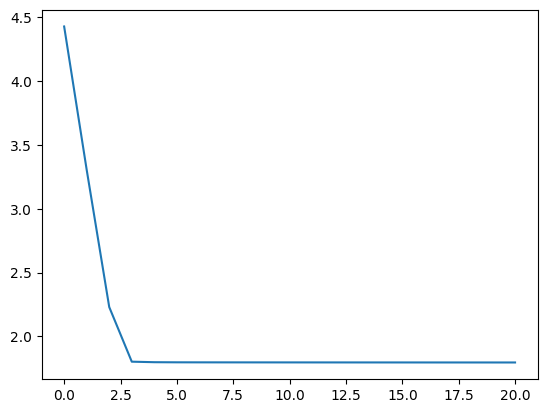

In [99]:
%%time

# ---- INSIRA SEU CÓDIGO AQUI
w_in = 1*np.zeros(X_train.shape[1])
b_in = 10
alpha = 0.001
num_iters = 20
w, b, J_history, w_history, b_history = gradient_descent(X_train, y_train, w_in, b_in, alpha, num_iters)

x = np.arange(len(J_history))
plt.plot(x,J_history)
# ----

## Exercício 3: Regressão logística - Scikit-learn

O objetivo deste exercício é obter os memos resultados do exercício acima usando a funcionalidade já existente no scikit-learn (`LogisticRegression`). Calcule também a acurácia usando a função `score` e faça um `plt.scatter` com código de cor correspondendo a sucesso/fracasso.

Acurácia:  0.8333333333333334


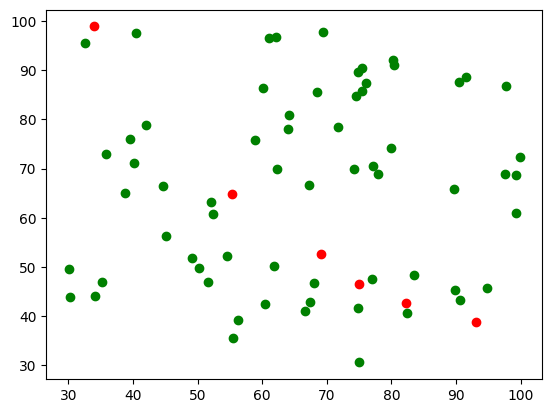

In [100]:
# ---- INSIRA SEU CÓDIGO AQUI
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
score = model.score(X_test,y_test)
print("Acurácia: ", score)
df_failed = X_train[y_train.iloc[:]!=model.predict(X_train)]
df_succeed = X_train[y_train.iloc[:]==model.predict(X_train)]

plt.scatter(df_failed.iloc[:,0],df_failed.iloc[:,1], color="red")
plt.scatter(df_succeed.iloc[:,0],df_succeed.iloc[:,1], color="green")
# ----

# Parte 2: Regularização

## Revisão teórica

### Motivação
Modelos de classificação tendem a **sobreajustar** quando há muitas *features* ou correlações fortes. A **regularização** introduz um termo de penalização no objetivo para controlar a complexidade do modelo, reduzindo variância e melhorando a generalização, sem alterar a forma do classificador logístico.

### Modelo de Regressão Logística (inalterado)
A predição probabilística continua sendo dada pela composição de uma combinação linear com a sigmoide:
$$
f_{\mathbf{w},b}(\mathbf{x}) = g(\mathbf{w}\cdot \mathbf{x} + b)\,, \tag{1}
$$
$$
g(z) = \frac{1}{\,1 + e^{-z}\,}\,. \tag{2}
$$

### Função de Custo Regularizada
A regularização modifica a função de custo adicionando uma penalização aos pesos. Em **L2 (Ridge)**, penalizamos a norma quadrática dos pesos (não se regulariza o viés $b$):
$$
J_\lambda(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \Big[ \text{loss}\!\big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}),\, y^{(i)}\big) \Big] \;+\; \frac{\lambda}{2m}\,\|\mathbf{w}\|_2^2\,. \tag{3}
$$
Alternativamente, em **L1 (Lasso)**:
$$
J_\lambda^{(L1)}(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \Big[ \text{loss}\!\big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}),\, y^{(i)}\big) \Big] \;+\; \frac{\lambda}{m}\,\|\mathbf{w}\|_1\,. \tag{4}
$$
Aqui, a perda logarítmica binária permanece:
$$
\text{loss}\big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}),\, y^{(i)}\big) = -\,y^{(i)} \log\!\Big(f_{\mathbf{w},b}\big( \mathbf{x}^{(i)} \big)\Big)\;-\;\big(1 - y^{(i)}\big)\,\log\!\Big(1 - f_{\mathbf{w},b}\big( \mathbf{x}^{(i)} \big)\Big)\,. \tag{5}
$$

### Gradientes (L2) e Subgradientes (L1)
Para **L2**, os gradientes tornam-se:
$$
\frac{\partial J_\lambda(\mathbf{w},b)}{\partial w_j} = \frac{1}{m}\sum_{i=0}^{m-1} \Big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}\Big)\,x_{j}^{(i)} \;+\; \frac{\lambda}{m}\,w_j\,, \quad j=0,\dots,n-1\,, \tag{6a}
$$
$$
\frac{\partial J_\lambda(\mathbf{w},b)}{\partial b} = \frac{1}{m}\sum_{i=0}^{m-1} \Big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}\Big)\,. \tag{6b}
$$
Para **L1**, usa-se **subgradiente** nos pesos:
$$
\partial_{w_j} J_\lambda^{(L1)}(\mathbf{w},b) \;\ni\; \frac{1}{m}\sum_{i=0}^{m-1} \Big(f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}\Big)\,x_{j}^{(i)} \;+\; \frac{\lambda}{m}\,\operatorname{sgn}(w_j)\,, \tag{7}
$$
onde $\operatorname{sgn}(0)\in[-1,1]$. Em ambos os casos, o viés $b$ não é penalizado e mantém o gradiente da regressão logística sem regularização.

### Ajuste de Parâmetros por Gradiente
O esquema de atualização preserva a forma, acrescentando apenas o termo de penalização no passo de $\mathbf{w}$ (L2) ou usando subgradientes (L1):
$$
\begin{align*}
& \text{Repeat } \{ \\
& \quad b \;:=\; b \;-\; \alpha \;\frac{\partial J_\lambda(\mathbf{w},b)}{\partial b}, \tag{8a} \\
& \quad w_j \;:=\; w_j \;-\; \alpha \;\frac{\partial J_\lambda(\mathbf{w},b)}{\partial w_j}, \quad j = 0,\ldots,n-1. \tag{8b}\\
& \}
\end{align*}
$$
A escolha de $\lambda>0$ controla o compromisso viés–variância: maiores valores induzem pesos menores e fronteiras mais “suaves”.

### Interpretação e Regra de Decisão
A interpretação probabilística permanece: $f_{\mathbf{w},b}(\mathbf{x}) \approx P(y=1\mid \mathbf{x})$. A regra de decisão é a mesma:
- Se $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) \geq 0.5$, então $\hat{y}^{(i)}=1$; caso contrário, $\hat{y}^{(i)}=0$.
A regularização tende a reduzir a variância do classificador e pode melhorar desempenho fora da amostra, especialmente em cenários com muitas *features* ou colinearidade.

### Resumo
A regularização adiciona uma penalização aos pesos na função de custo: **L2** encolhe coeficientes de modo suave e estabiliza o problema; **L1** promove esparsidade, realizando seleção de variáveis. Em ambos os casos, o modelo logístico e sua interpretação probabilística permanecem, enquanto a complexidade é controlada via $\lambda$.


## Exercício 4: Preparação dos dados

Para os próximos dois exercícios, vamos usar um conjunto de dados diferentes. Uma fábrica produz microchips e o objetivo do modelo de regressão logística é prever se um dado microchip passará pelos testes de qualidade (QA, de _quality assurance_).

### Criando o conjunto de dados

In [101]:
!mkdir -p ./data
!touch ./data/microchips.csv

In [102]:
microchips_data = """0.051267,0.69956,1
-0.092742,0.68494,1
-0.21371,0.69225,1
-0.375,0.50219,1
-0.51325,0.46564,1
-0.52477,0.2098,1
-0.39804,0.034357,1
-0.30588,-0.19225,1
0.016705,-0.40424,1
0.13191,-0.51389,1
0.38537,-0.56506,1
0.52938,-0.5212,1
0.63882,-0.24342,1
0.73675,-0.18494,1
0.54666,0.48757,1
0.322,0.5826,1
0.16647,0.53874,1
-0.046659,0.81652,1
-0.17339,0.69956,1
-0.47869,0.63377,1
-0.60541,0.59722,1
-0.62846,0.33406,1
-0.59389,0.005117,1
-0.42108,-0.27266,1
-0.11578,-0.39693,1
0.20104,-0.60161,1
0.46601,-0.53582,1
0.67339,-0.53582,1
-0.13882,0.54605,1
-0.29435,0.77997,1
-0.26555,0.96272,1
-0.16187,0.8019,1
-0.17339,0.64839,1
-0.28283,0.47295,1
-0.36348,0.31213,1
-0.30012,0.027047,1
-0.23675,-0.21418,1
-0.06394,-0.18494,1
0.062788,-0.16301,1
0.22984,-0.41155,1
0.2932,-0.2288,1
0.48329,-0.18494,1
0.64459,-0.14108,1
0.46025,0.012427,1
0.6273,0.15863,1
0.57546,0.26827,1
0.72523,0.44371,1
0.22408,0.52412,1
0.44297,0.67032,1
0.322,0.69225,1
0.13767,0.57529,1
-0.0063364,0.39985,1
-0.092742,0.55336,1
-0.20795,0.35599,1
-0.20795,0.17325,1
-0.43836,0.21711,1
-0.21947,-0.016813,1
-0.13882,-0.27266,1
0.18376,0.93348,0
0.22408,0.77997,0
0.29896,0.61915,0
0.50634,0.75804,0
0.61578,0.7288,0
0.60426,0.59722,0
0.76555,0.50219,0
0.92684,0.3633,0
0.82316,0.27558,0
0.96141,0.085526,0
0.93836,0.012427,0
0.86348,-0.082602,0
0.89804,-0.20687,0
0.85196,-0.36769,0
0.82892,-0.5212,0
0.79435,-0.55775,0
0.59274,-0.7405,0
0.51786,-0.5943,0
0.46601,-0.41886,0
0.35081,-0.57968,0
0.28744,-0.76974,0
0.085829,-0.75512,0
0.14919,-0.57968,0
-0.13306,-0.4481,0
-0.40956,-0.41155,0
-0.39228,-0.25804,0
-0.74366,-0.25804,0
-0.69758,0.041667,0
-0.75518,0.2902,0
-0.69758,0.68494,0
-0.4038,0.70687,0
-0.38076,0.91886,0
-0.50749,0.90424,0
-0.54781,0.70687,0
0.10311,0.77997,0
0.057028,0.91886,0
-0.10426,0.99196,0
-0.081221,1.1089,0
0.28744,1.087,0
0.39689,0.82383,0
0.63882,0.88962,0
0.82316,0.66301,0
0.67339,0.64108,0
1.0709,0.10015,0
-0.046659,-0.57968,0
-0.23675,-0.63816,0
-0.15035,-0.36769,0
-0.49021,-0.3019,0
-0.46717,-0.13377,0
-0.28859,-0.060673,0
-0.61118,-0.067982,0
-0.66302,-0.21418,0
-0.59965,-0.41886,0
-0.72638,-0.082602,0
-0.83007,0.31213,0
-0.72062,0.53874,0
-0.59389,0.49488,0
-0.48445,0.99927,0
-0.0063364,0.99927,0
0.63265,-0.030612,0"""

with open('./data/microchips.csv', 'w') as f:
    f.write(microchips_data)

# Importando dados
X_features = ['Microchip Test 1', 'Microchip Test 2']
y_name = ['Pass']
data = pd.read_csv("./data/microchips.csv", header=None, names=X_features + y_name)

### 4.a) Crie a matriz de treino $X_{\rm train}$, o vetor de variáveis alvo $y_{\rm train}$

In [103]:
# ---- INSIRA SEU CÓDIGO AQUI
X_data = data.iloc[:,0:2]
y_data = data.iloc[:,2]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.30, random_state=42)

# ----

### 4b) Explore (rapidamente) os dados

**Inspecione a tabela com funcionalidade da biblioteca pandas e faça um scatterplot dos dados, usando a coluna "Admitted" como estilo do marcador (cor, forma ou ambos).**

_Obs: não gaste muito tempo neste exercício. Por outro lado, é sempre importante inspecionar rapidamente os dados._


> Besides `display()`, you can use several other methods to inspect a pandas DataFrame:
>
> - `.head()`: Shows the first 5 rows (or a specified number) of the DataFrame. Useful for a quick look at the data structure.
> - `.info()`: Prints a concise summary of the DataFrame, including the index dtype > and column dtypes, non-null values and memory usage.
> - `.describe()`: Generates descriptive statistics of the DataFrame's numerical > columns, such as count, mean, standard deviation, minimum, and maximum.
> - `.shape`: Returns a tuple representing the dimensionality of the DataFrame (rows, > columns).

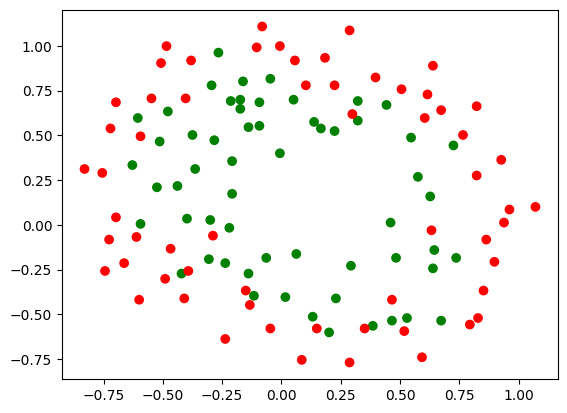

In [110]:
# ---- INSIRA SEU CÓDIGO AQUI
plt.scatter(data.iloc[:,0],data.iloc[:,1], color = np.where(data.iloc[:,2] == 1, "green", "red"))
# ----

### 4.c) Crie um conjunto de features polinomiais até ordem 6, contendo todos os dados cruzados

_Obs: Use o método `PolynomialFeatures` da biblioteca Scikit-learn. Use a opção `include_bias=False` para não introduzir uma feature constante._

In [105]:
# ---- INSIRA SEU CÓDIGO AQUI
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(6, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
# ----

## Exercício 5: Regressão logística com regularização - Método do gradiente

A nova matriz de dados `X_poly_train` possui 27 features por linha, estando bem suscetível ao problema de _overfitting_. Neste exercício, vamos adaptar e rodar o método do gradiente para o caso com regularização. Ao longo do exercício, será possível reutilizar as funções definidas no exercício 2 e incluir a regularização adicionalmente.

### 5.a) Implementando as funções

Será necessário definir as seguintes funções:

- `compute_cost_reg` implementa a equação (3) acima;
- `compute_gradient_reg` implementa as equações (6a) e (6b) acima;
- `gradient_descent` é idêntico ao método desenvolvido no Exercício 2, exceto pela modificação das chamadas às duas funções acima.

In [106]:
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples.

    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value
      w : (ndarray Shape (n,))  values of parameters of the model
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar, float) Controls amount of regularization

    Returns:
      total_cost : (scalar)     cost
    """

    # ---- INSIRA SEU CÓDIGO AQUI
    m = len(y)
    f = sigmoid(w @ X.T + b)
    losses = -y * np.log(f) - (1-y)*np.log(1-f)

    cost = losses.sum()/m + lambda_/(2*m)*(w @ w)
    # ----

    return cost


def compute_gradient_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the gradient for logistic regression with regularization

    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (ndarray Shape (m,))  target value
      w : (ndarray Shape (n,))  values of parameters of the model
      b : (scalar)              value of bias parameter of the model
      lambda_ : (scalar,float)  regularization constant
    Returns
      dj_db : (scalar)             The gradient of the cost w.r.t. the parameter b.
      dj_dw : (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w.
    """

    # ---- INSIRA SEU CÓDIGO AQUI
    m = len(y)
    dif = sigmoid(w @ X.T + b) - y
    dj_dw = (X.T @ dif)/m  + w*lambda_/m
    dj_db = dif.sum()/m
    # ----

    return dj_dw, dj_db


def gradient_descent(X, y, w_in, b_in, alpha, num_iters, lambda_):
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray (m, n)) : Data, m examples with n features each
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): initial model weight parameters
      b_in (scalar)      : initial model bias parameter
      alpha (float)      : Learning rate
      num_iters (int)    : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,))                   : Updated values of parameters
      b (scalar)                         : Updated value of parameter
      J_history (ndarray (num_iters,))   : History of cost values
      w_history (ndarray (num_iters, n)) : History of parameters w
      b_history (ndarray (num_iters,))   : History of parameters b
      """

    # ---- INSIRA SEU CÓDIGO AQUI
    w = w_in
    b = b_in
    w_history = [w]
    b_history = [b]
    J_history = [compute_cost_reg(X,y,w,b,lambda_)]

    for i in range(num_iters):
      dj_dw, dj_db = compute_gradient_reg(X,y,w,b,lambda_)
      w -= alpha*dj_dw
      b -= alpha*dj_db

      w_history.append(w)
      b_history.append(b)
      J_history.append(compute_cost_reg(X,y,w,b,lambda_))
    # ----

    return w, b, J_history, w_history, b_history

### 5.b) Treine o modelo, faça previsões e inspecione graficamente os resultados

Faça a regressão logística nos dados e verifique graficamente que o comportamento da função de custo está como o esperado.

In [119]:
%%time

# ---- INSIRA SEU CÓDIGO AQUI
w_in = 1*np.zeros(X_train.shape[1])
b_in = 10
alpha = 0.1
num_iters = 500
lambda_ = 1
w, b, J_history, w_history, b_history = gradient_descent(X_test, y_test, w_in, b_in, alpha, num_iters, lambda_)

x = np.arange(len(J_history))
print("final cost: ", compute_cost_reg(X_poly_train,y_test,w,b,lambda_))
plt.plot(x,J_history)
# ----

Exception: Dot product shape mismatch, (2,) vs (27, 82)

## Exercício 6: Regressão logística com regularização - Scikit-learn

O objetivo deste exercício é obter os mesmos resultados do exercício acima usando a funcionalidade já existente no scikit-learn. Para tanto, usaremos novamente a função `PolynomialFeatures` para processar os dados de entrada `X_train`, seguida da função `LogisticRegression` para realizar o treinamento.

Para combinar as operações, usaremos a função `Pipeline` que, como indica o nome, cria uma sequência de operações (i.e. um _pipeline_) definidas pelo usuário.

_PS. Como as features já estão escalonadas, não usaremos o `StandardScaler` para renormalizar os dados._

_PPS. Como criaremos novamente as features polinomiais, use `X_train` e não `X_poly_train` quando realizar o treinamento no ex 6.b)_

### 6.a) Defina um pipeline em scikit-learn que crie features polinomiais e defina um modelo de regressão logística com regularização 'ridge'

In [108]:
# ---- INSIRA SEU CÓDIGO AQUI
poly = PolynomialFeatures(6, include_bias=False)

# ----

### 6.b) Treine o modelo, faça previsões e inspecione graficamente os resultados

In [109]:
# ---- INSIRA SEU CÓDIGO AQUI
# ...
# ----